# Analisi dati prodotti dalle simulazioni di VELLO

### 0. Preparazione ambiente

In [5]:
# Installazione ibrerie
!pip install networkx python-louvain matplotlib mycolorpy scikit-learn scipy matplotlib numpy pandas seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9407 sha256=dabb08bbadc6ff95dd35884ec97c38b7169c22c2c21fb215645818247ee6100e
  Stored in directory: /root/.cache/pip/wheels/4d/7c/b6/79b198e4ec43f915fbdf967953d48b89a18893b12aa9df0ae2
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3873 sha256=23de9512e827c9db4c0081749b0ed26839546415b7713ef84f522ee9482531d7
  Stored in directory: /root/.cache/pip/wheels/b9/56/d6/a163bcbec3bb69f3f7797b1b542870b18d7e31ff5dbc0b87e3
Successfully built python-louvain mycolorpy

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install networkx==3.3

ERROR: Ignored the following versions that require a different python version: 3.3 Requires-Python >=3.10; 3.3rc0 Requires-Python >=3.10; 3.4rc0 Requires-Python >=3.10
ERROR: Could not find a version that satisfies the requirement networkx==3.3 (from versions: 0.34, 0.35, 0.35.1, 0.36, 0.37, 0.99, 1.0rc1, 1.0, 1.0.1, 1.1, 1.2rc1, 1.2, 1.3rc1, 1.3, 1.4rc1, 1.4, 1.5rc1, 1.5, 1.6rc1, 1.6, 1.7rc1, 1.7, 1.8rc1, 1.8, 1.8.1, 1.9rc1, 1.9, 1.9.1, 1.10rc2, 1.10, 1.11rc1, 1.11rc2, 1.11, 2.0, 2.1, 2.2rc1, 2.2, 2.3rc3, 2.3rc4, 2.3, 2.4rc1, 2.4rc2, 2.4, 2.5rc1, 2.5, 2.5.1, 2.6rc1, 2.6rc2, 2.6, 2.6.1, 2.6.2, 2.6.3, 2.7rc1, 2.7, 2.7.1, 2.8rc1, 2.8, 2.8.1rc1, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.8.5, 2.8.6, 2.8.7, 2.8.8, 3.0b1, 3.0rc1, 3.0, 3.1rc0, 3.1, 3.2rc0, 3.2, 3.2.1)
ERROR: No matching distribution found for networkx==3.3

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [6]:
# Importare le librerie
import json
import os
import networkx as nx
import networkx.algorithms.community as nx_comm
import community

import community as community_louvain
from collections import defaultdict,Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import pi
import pandas as pd
from matplotlib import pyplot as plt
from mycolorpy import colorlist as mcp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Caricamento del file JSON
with open('simulations.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

In [5]:
#Estrazione dati agenti# Estrarre i dati degli agenti
agents = data['simulations'][0]['agents']

# Creare un DataFrame per gli agenti
df_agents = pd.DataFrame([{
    'agent_id': agent['agent_id'],
    'age': agent['age'],
    'interest': agent['interest'],
    'apertura_mentale': agent['big5_values:']['apertura_mentale'],
    'coscienziosità': agent['big5_values:']['coscienziosità'],
    'estroversione': agent['big5_values:']['estroversione'],
    'gradevolezza': agent['big5_values:']['gradevolezza'],
    'nevroticismo': agent['big5_values:']['nevroticismo'],
    'activity_level': agent['activity_level'],
    'activity_degree': agent['activity_degree'],
    'malicious': agent['malicious'],
    'num_posts': len(agent.get('published_post', [])),
    'num_comments': sum([len(post.get('comments', [])) for post in agent.get('published_post', [])])
} for agent in agents])

## 1. Analisi profili degli agenti

Distribuzioni età degli agenti

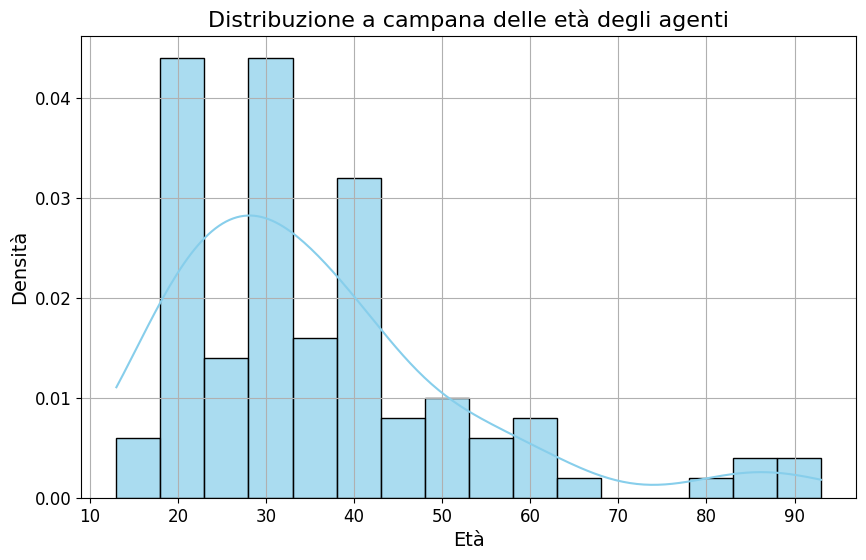

In [25]:
plt.figure(figsize=(10, 6))
ages=df_agents['age']
# Impostiamo i bin per l'istogramma in base alla distribuzione effettiva delle età
bin_width = 5
bins = np.arange(min(ages), max(ages) + bin_width, bin_width)
 
# Istogramma delle età con la curva KDE
sns.histplot(ages, bins=bins, color="skyblue", edgecolor="black", kde=True, stat="density", alpha=0.7)
 
plt.title("Distribuzione a campana delle età degli agenti", fontsize=16)
plt.xlabel("Età", fontsize=14)
plt.ylabel("Densità", fontsize=14)

# Aumenta la dimensione dei tick sulle assi
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)  
# Mostra il grafico
plt.show()

Analisi valori BIg 5

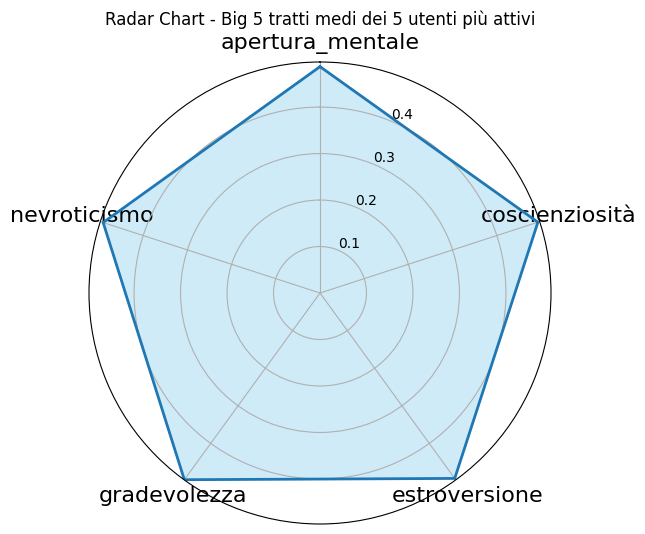

In [20]:
agents = data['simulations'][0]['agents']

# Calcolo dell'attività degli agenti in base al numero di post/commenti
agents_activity = []
for agent in agents:
    activity = len(agent.get('published_post', [])) + sum([len(post['comments']) for post in agent.get('published_post', [])])
    agents_activity.append({'agent_id': agent['agent_id'], 'activity': activity, 'big5_values': agent['big5_values:']})

# Ordinamento degli agenti per livello di attività
top_10_active_agents = sorted(agents_activity, key=lambda x: x['activity'], reverse=True)[:]

# Calcolo della media dei Big 5 per i 10 utenti più attivi
big5_traits = ['apertura_mentale', 'coscienziosità', 'estroversione', 'gradevolezza', 'nevroticismo']
big5_means = {trait: np.mean([agent['big5_values'][trait] for agent in top_10_active_agents]) for trait in big5_traits}

# Impostazione del radar chart
labels = big5_traits
values = list(big5_means.values())
values += values[:1]  # chiusura del grafico

N = len(labels)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Creazione del radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], labels,fontsize=16)

# Cambiare il colore del riempimento in skyblue
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, 'skyblue', alpha=0.4)

plt.title('Radar Chart - Big 5 tratti medi dei 5 utenti più attivi')
plt.show()

## Analisi contenuti e interessi

Totale post e commenti

In [6]:
# Funzione per calcolare i post e commenti totali sia per tutti gli agenti che per gli agenti malevoli
def calculate_total_posts_comments(data):
    total_posts = 0
    total_comments = 0
    malicious_posts = 0
    malicious_comments = 0

    # Itera attraverso gli agenti
    for agent in data['simulations'][0]['agents']:
        # Conta i post pubblicati dall'agente
        agent_posts = len(agent.get('published_post', []))
        total_posts += agent_posts

        # Conta i commenti pubblicati dall'agente
        agent_comments = len(agent.get('last_feed', []))
        total_comments += agent_comments

        # Se l'agente è malevolo, somma i post e commenti malevoli
        if agent['malicious']:
            malicious_posts += agent_posts
            malicious_comments += agent_comments

    return total_posts, total_comments, malicious_posts, malicious_comments

# Esecuzione del calcolo di post e commenti totali
total_posts, total_comments, malicious_posts, malicious_comments = calculate_total_posts_comments(data)

# Stampa dei risultati
print(f"Numero totale di post pubblicati: {total_posts}")
print(f"Numero totale di commenti pubblicati: {total_comments}")
print(f"Numero totale di post pubblicati dagli agenti malevoli: {malicious_posts}")
print(f"Numero totale di commenti pubblicati dagli agenti malevoli: {malicious_comments}")


Numero totale di post pubblicati: 247
Numero totale di commenti pubblicati: 2000
Numero totale di post pubblicati dagli agenti malevoli: 58
Numero totale di commenti pubblicati dagli agenti malevoli: 260


Analisi agenti che hanno avuto più interazioni

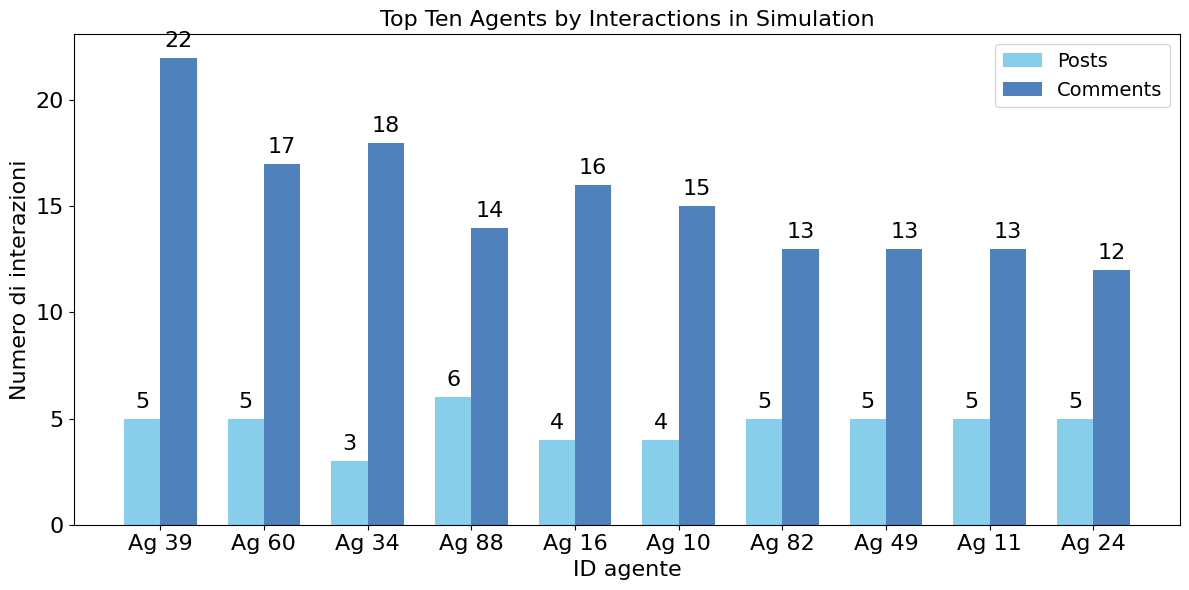

In [6]:
def count_interactions(data):
    interaction_counts = {}
    
    # Itera attraverso gli agenti
    for agent in data['simulations'][0]['agents']:
        agent_id = agent['agent_id']
        post_count = len(agent['published_post'])
        comment_count = sum(len(post.get('comments', [])) for post in agent['published_post'])
        
        interaction_counts[agent_id] = {
            'posts': post_count,
            'comments': comment_count
        }
    
    return interaction_counts

# Funzione per visualizzare i risultati
def plot_top_ten_interactions(interaction_counts):
    # Ordina gli agenti per il numero totale di interazioni (post + commenti)
    sorted_agents = sorted(interaction_counts.items(), key=lambda x: x[1]['posts'] + x[1]['comments'], reverse=True)
    top_ten = sorted_agents[:10]

    agent_ids = [f'Ag {agent[0]}' for agent in top_ten]
    post_counts = [agent[1]['posts'] for agent in top_ten]
    comment_counts = [agent[1]['comments'] for agent in top_ten]

    x = np.arange(len(agent_ids))  # Larghezza delle barre
    width = 0.35  # Larghezza delle barre

    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width/2, post_counts, width, label='Posts', color='skyblue')
    bars2 = ax.bar(x + width/2, comment_counts, width, label='Comments', color='#4f81bd')

    # Aggiungi etichette, titolo e perso16nalizzazioni con fontsize aumentato
    ax.set_xlabel('ID agente', fontsize=16)
    ax.set_ylabel('Numero di interazioni', fontsize=16)
    ax.set_title('Top Ten Agents by Interactions in Simulation', fontsize=16)
    
    ax.set_xticks(x)
    ax.set_xticklabels(agent_ids, fontsize=16)

    ax.tick_params(axis='y', labelsize=16)
    
    # Legenda con fontsize più grande
    ax.legend(fontsize=14)

    # Aggiungi annotazioni sopra le barre con fontsize aumentato
    for bar in bars1:
        yval = bar.get_height()
        ax.annotate(yval,
                    xy=(bar.get_x() + bar.get_width() / 2, yval),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=16)

    for bar in bars2:
        yval = bar.get_height()
        ax.annotate(yval,
                    xy=(bar.get_x() + bar.get_width() / 2, yval),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=16)

    plt.tight_layout()
    plt.show()

# Esegui il calcolo e visualizza il grafico
interaction_counts = count_interactions(data)
plot_top_ten_interactions(interaction_counts)

Interazioni medie

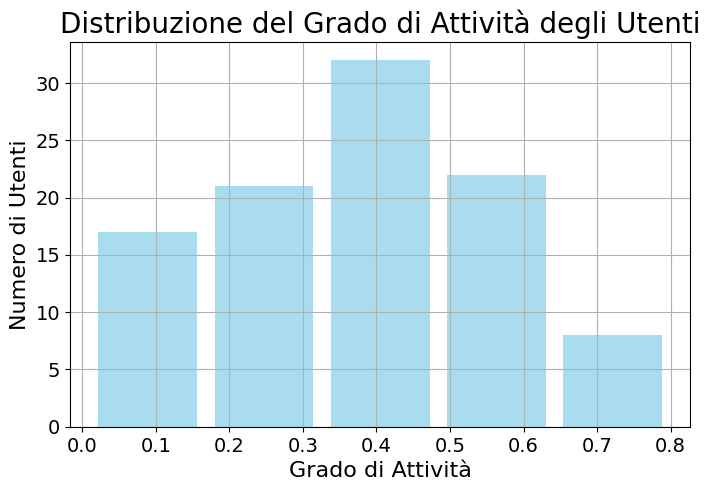

In [52]:
activity_degrees = [agent['activity_degree'] for agent in data['simulations'][0]['agents']]

# Creazione del grafico della distribuzione del grado di attività
plt.figure(figsize=(8, 5))
plt.hist(activity_degrees, bins=5, color='skyblue', alpha=0.7, rwidth=0.85)

# Ingrandire le scritte
plt.title('Distribuzione del Grado di Attività degli Utenti', fontsize=20)
plt.xlabel('Grado di Attività', fontsize=16)
plt.ylabel('Numero di Utenti', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [8]:
# Media di post e commenti per agente
mean_posts_per_agent = df_agents['num_posts'].mean()
mean_comments_per_agent = df_agents['num_comments'].mean()

print(f"Media di post per agente: {mean_posts_per_agent}")
print(f"Media di commenti per agente: {mean_comments_per_agent}")

Media di post per agente: 2.47
Media di commenti per agente: 4.97


Categorie più popolari

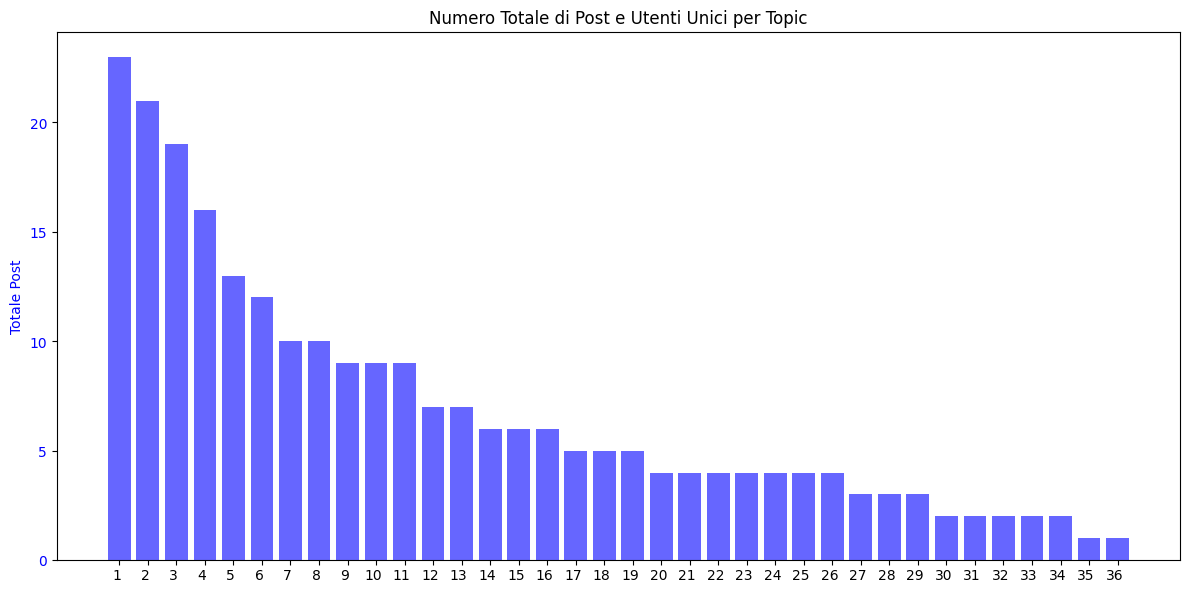

In [9]:
import matplotlib.pyplot as plt

# Creare un dizionario per tenere traccia dei post e degli agenti per ogni topic
topic_data = {}

# Iterare sugli agenti e i loro post
for agent in agents:
    for post in agent.get('published_post', []):
        topic = post['topic']
        # Se il topic non è già nel dizionario, inizializzalo
        if topic not in topic_data:
            topic_data[topic] = {
                'total_posts': 0,      # Numero totale di post per il topic
                'agents': set()        # Set per tenere traccia degli agenti unici
            }
        # Incrementa il numero totale di post per il topic
        topic_data[topic]['total_posts'] += 1
        # Aggiungi l'agente al set degli agenti che hanno pubblicato su questo topic
        topic_data[topic]['agents'].add(agent['agent_id'])

# Ordinare i risultati in base al numero totale di post
sorted_topics = sorted(topic_data.items(), key=lambda x: x[1]['total_posts'], reverse=True)

# Estrarre i dati per il grafico
topics = [topic for topic, data in sorted_topics]
total_posts = [data['total_posts'] for topic, data in sorted_topics]
unique_agents = [len(data['agents']) for topic, data in sorted_topics]

# Creare il grafico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Creare un grafico a barre per il numero totale di post
bars = ax1.bar(range(len(topics)), total_posts, color='b', alpha=0.6, label='Totale Post')
ax1.set_xticks(range(len(topics)))  # Imposta i tick per i numeri
ax1.set_xticklabels([])  # Nascondi le etichette dei temi

ax1.set_ylabel('Totale Post', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Aggiungere i numeri sotto le barre
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, -1, str(i + 1), 
             ha='center', va='bottom', fontsize=10, color='black')

# Aggiungere il titolo
plt.title('Numero Totale di Post e Utenti Unici per Topic')
plt.tight_layout()
plt.show()


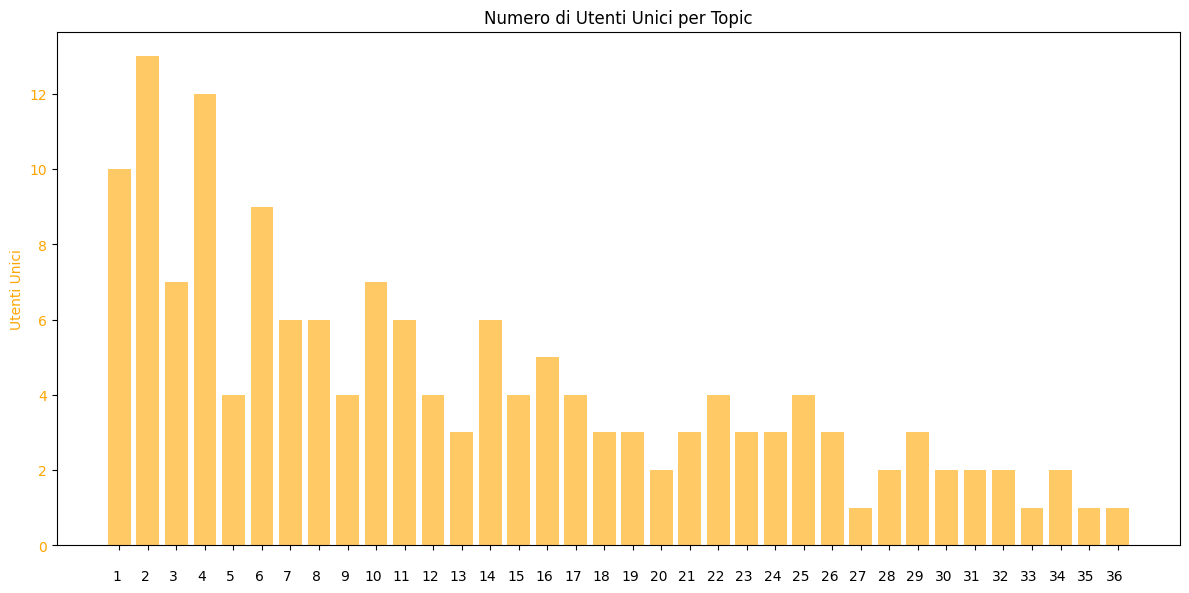

In [10]:
import matplotlib.pyplot as plt

# Creare un dizionario per tenere traccia dei post e degli agenti per ogni topic
topic_data = {}

# Iterare sugli agenti e i loro post
for agent in agents:
    for post in agent.get('published_post', []):
        topic = post['topic']
        # Se il topic non è già nel dizionario, inizializzalo
        if topic not in topic_data:
            topic_data[topic] = {
                'total_posts': 0,      # Numero totale di post per il topic
                'agents': set()        # Set per tenere traccia degli agenti unici
            }
        # Incrementa il numero totale di post per il topic
        topic_data[topic]['total_posts'] += 1
        # Aggiungi l'agente al set degli agenti che hanno pubblicato su questo topic
        topic_data[topic]['agents'].add(agent['agent_id'])

# Ordinare i risultati in base al numero totale di post
sorted_topics = sorted(topic_data.items(), key=lambda x: x[1]['total_posts'], reverse=True)

# Estrarre i dati per il grafico
topics = [topic for topic, data in sorted_topics]
unique_agents = [len(data['agents']) for topic, data in sorted_topics]  # Conta solo gli agenti che hanno pubblicato

# Creare il grafico
fig, ax = plt.subplots(figsize=(12, 6))

# Creare un grafico a barre per il numero di utenti unici
bars_unique = ax.bar(range(len(topics)), unique_agents, color='orange', alpha=0.6, label='Utenti Unici')

# Imposta i tick per i numeri
ax.set_xticks(range(len(topics)))
ax.set_xticklabels([])  # Nascondi le etichette dei temi

ax.set_ylabel('Utenti Unici', color='orange')
ax.tick_params(axis='y', labelcolor='orange')

# Aggiungere i numeri sotto le barre
for i, bar in enumerate(bars_unique):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, -1, str(i + 1), 
             ha='center', va='bottom', fontsize=10, color='black')

# Aggiungere il titolo
plt.title('Numero di Utenti Unici per Topic')
plt.tight_layout()
plt.show()



In [11]:
number_to_topic_dict = {i + 1: topic for i, topic in enumerate(topics)}

# Stampare il dizionario
print("Dizionario dei temi:")
for number, topic in number_to_topic_dict.items():
    print(f"{number}: {topic}")


Dizionario dei temi:
1: Giochi di ruolo (RPG), E-sport
2: Calcio, Tennis, Surf
3: Libri d'arte, Storia
4: Moda streetwear, Stile vintage, Alta moda
5: Giochi indie, Giochi per dispositivi mobili
6: Moda streetwear, Sviluppo personale
7: Tecnologia dell'informazione, Intelligenza artificiale
8: Politica internazionale, Criptovalute
9: Politica internazionale
10: Turismo culturale, Viaggi in camper
11: Viaggi in camper, Turismo culturale
12: Musica classica, Riduzione della plastica
13: Criptovalute, Agricoltura biologica
14: Ambiente e cambiamenti climatici, Riduzione della plastica
15: Fisica, Tecnologia dell'informazione
16: Politica internazionale, Economia
17: Sport, Calcio
18: Politica internazionale, Energia rinnovabile
19: Calcio, Sport
20: Giochi videoludici, Fantascienza
21: Economia
22: Storia, Viaggi in camper
23: Conservazione della biodiversita', Tecnologia dell'informazione
24: Turismo culturale, Ricette vegetariane/vegane
25: Tecnologia dell'informazione, Criptovalute
26:

Comfronto tra tremi trattati dalle notizie e temi trattati dalgli utenti

Analisi dei temi trattati

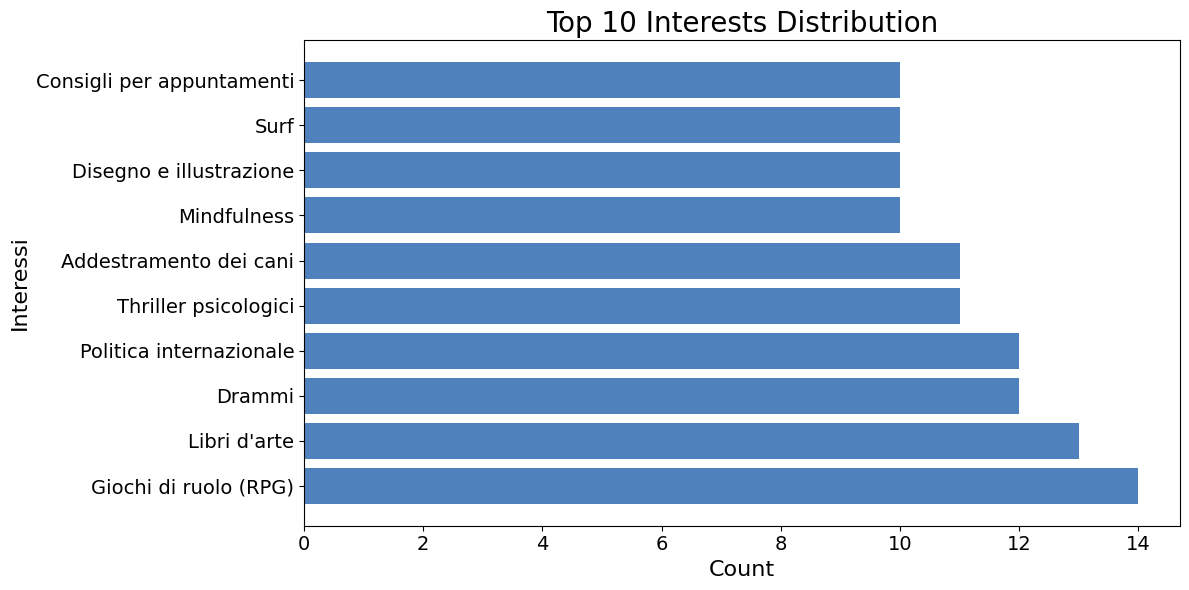

In [7]:
def analyze_interests(data):
    interests_counter = Counter()
    
    # Itera attraverso gli agenti
    for agent in data['simulations'][0]['agents']:
        interests = agent['interest'].split(', ')
        for interest in interests:
            interests_counter[interest] += 1  # Conta la distribuzione degli interessi

    return interests_counter

# Funzione per visualizzare i risultati
def plot_interests(interests_counter):
    # Estrarre la distribuzione degli interessi
    interests, interest_counts = zip(*interests_counter.most_common(10))

    plt.figure(figsize=(12, 6))
    plt.barh(interests, interest_counts, color='#4f81bd')
    
    # Ingrandire le scritte
    plt.xlabel('Count', fontsize=16)  # Dimensione del font per l'asse X
    plt.title('Top 10 Interests Distribution', fontsize=20)  # Dimensione del font per il titolo
    plt.ylabel('Interessi', fontsize=16)  # Dimensione del font per l'asse Y
    
    plt.xticks(fontsize=14)  # Dimensione del font per le etichette dell'asse X
    plt.yticks(fontsize=14)  # Dimensione del font per le etichette dell'asse Y

    plt.tight_layout()
    plt.show()

# Supponendo che 'data' contenga i dati JSON caricati
interests_counter = analyze_interests(data)
plot_interests(interests_counter)

Distribuzione degli itneressi

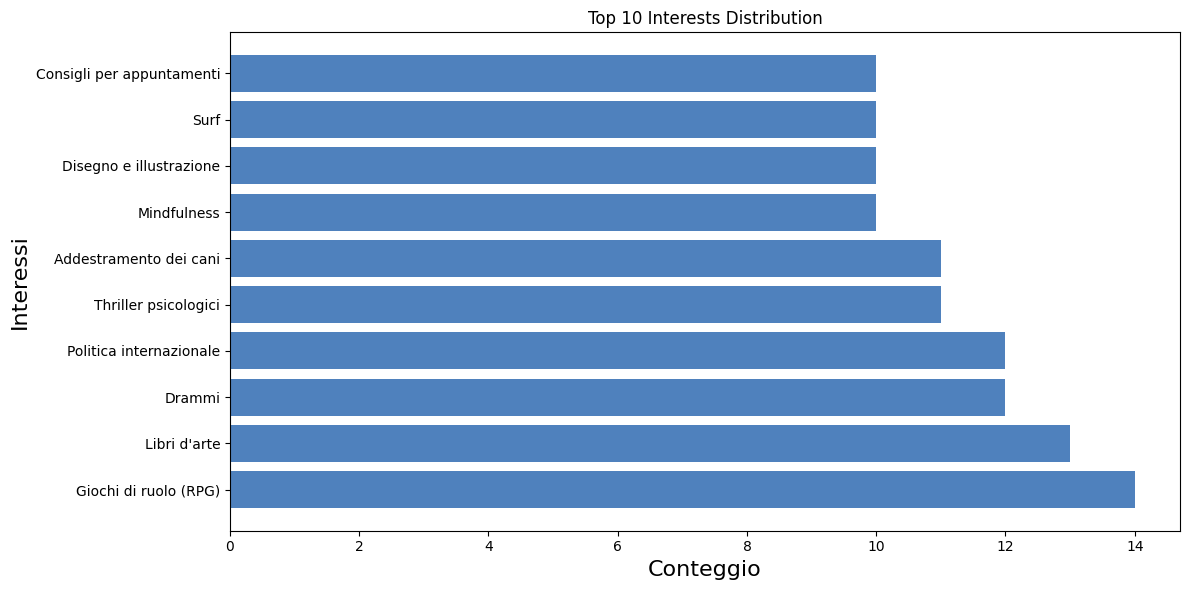

In [9]:
# Funzione per estrarre la distribuzione degli interessi
def analyze_interests(data):
    interests_counter = Counter()
    
    # Itera attraverso gli agenti
    for agent in data['simulations'][0]['agents']:
        interests = agent['interest'].split(', ')
        for interest in interests:
            interests_counter[interest] += 1  # Conta la distribuzione degli interessi

    return interests_counter

# Funzione per visualizzare i risultati
def plot_interests(interests_counter):
    # Estrarre la distribuzione degli interessi
    interests, interest_counts = zip(*interests_counter.most_common(10))

    plt.figure(figsize=(12, 6))
    plt.barh(interests, interest_counts, color='#4f81bd')
    plt.ylabel('Interessi',fontsize=16)
    plt.xlabel('Conteggio',fontsize=16)
    plt.title('Top 10 Interests Distribution')
    plt.tight_layout()
    plt.show()

interests_counter = analyze_interests(data)
plot_interests(interests_counter)


## 2. Interazioni con i contenuti

Most commented post

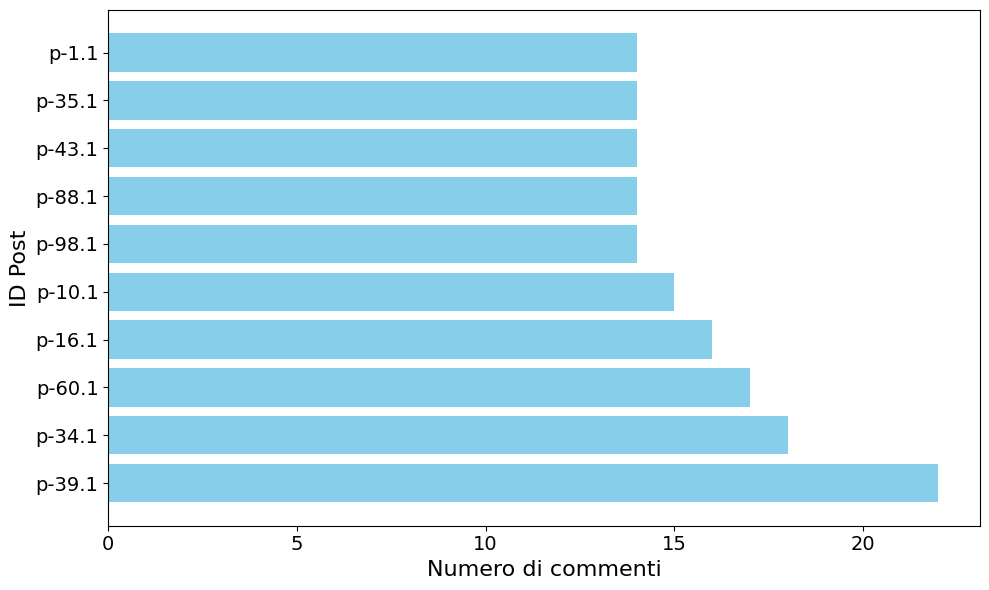

In [10]:
def most_commented_posts(data):
    post_comments_counter = Counter()

    # Itera attraverso gli agenti e i loro post pubblicati
    for agent in data['simulations'][0]['agents']:
        for post in agent.get('published_post', []):
            post_id = post['post_id']
            post_comments_counter[post_id] += len(post.get('comments', []))  # Conta i commenti per ogni post

    return post_comments_counter

# Funzione per visualizzare i post più commentati
def plot_most_commented_posts(post_comments_counter):
    # Estrai i post più commentati
    most_commented_posts, comment_counts = zip(*post_comments_counter.most_common(10))

    # Crea il grafico
    plt.figure(figsize=(10, 6))
    plt.barh(most_commented_posts, comment_counts, color='skyblue')
    
    # Ingrandire le scritte
    plt.xlabel('Numero di commenti', fontsize=16)  # Dimensione del font per l'asse X
    plt.ylabel('ID Post', fontsize=16)  # Dimensione del font per l'asse Y

    plt.xticks(fontsize=14)  # Dimensione del font per le etichette dell'asse X
    plt.yticks(fontsize=14)  # Dimensione del font per le etichette dell'asse Y
    
    plt.tight_layout()
    plt.show()

# Esecuzione del calcolo dei most commented posts
post_comments_counter = most_commented_posts(data)

# Visualizzazione
plot_most_commented_posts(post_comments_counter)


Top 10 topic by interaction count

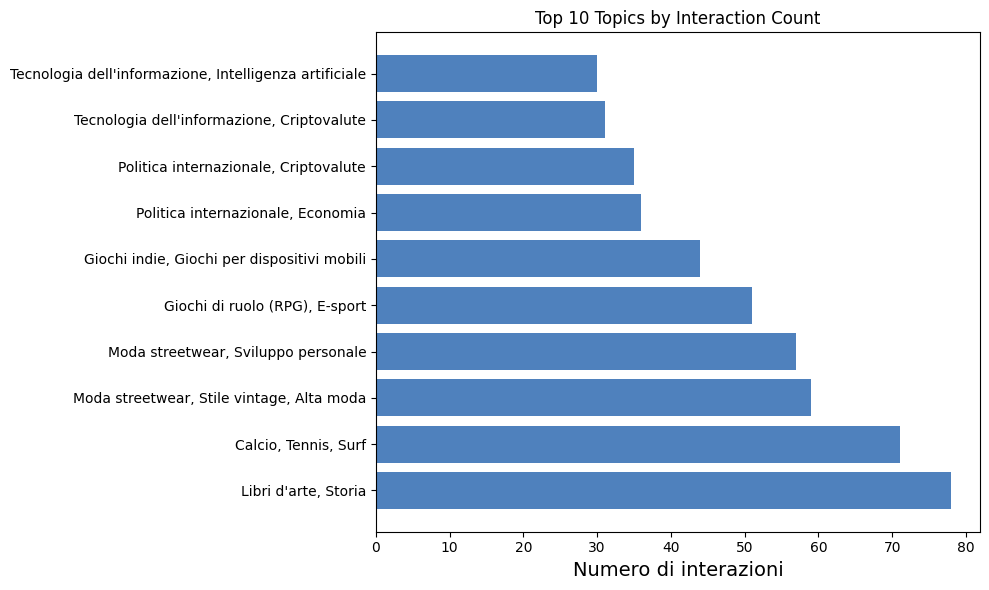

In [12]:
# Funzione per calcolare il numero di interazioni per ogni topic
def top_topics_by_interaction(data):
    topic_interaction_counter = Counter()

    # Itera attraverso gli agenti e i loro post pubblicati
    for agent in data['simulations'][0]['agents']:
        for post in agent.get('published_post', []):
            topic = post['topic']
            num_comments = len(post.get('comments', []))
            topic_interaction_counter[topic] += num_comments + 1  # Conta commenti + il post stesso come interazioni

    return topic_interaction_counter

# Funzione per visualizzare i top topics per interazione
def plot_top_topics_by_interaction(topic_interaction_counter):
    # Estrai i top topics più interattivi
    top_topics, interaction_counts = zip(*topic_interaction_counter.most_common(10))

    # Crea il grafico
    plt.figure(figsize=(10, 6))
    plt.barh(top_topics, interaction_counts, color='#4f81bd')
    plt.xlabel('Numero di interazioni',fontsize=14)
    plt.title('Top 10 Topics by Interaction Count')
    plt.tight_layout()
    plt.show()

# Esecuzione del calcolo dei top topics by interaction
topic_interaction_counter = top_topics_by_interaction(data)

# Visualizzazione
plot_top_topics_by_interaction(topic_interaction_counter)


## 3. Comportamenti attorno agli agenti negativi

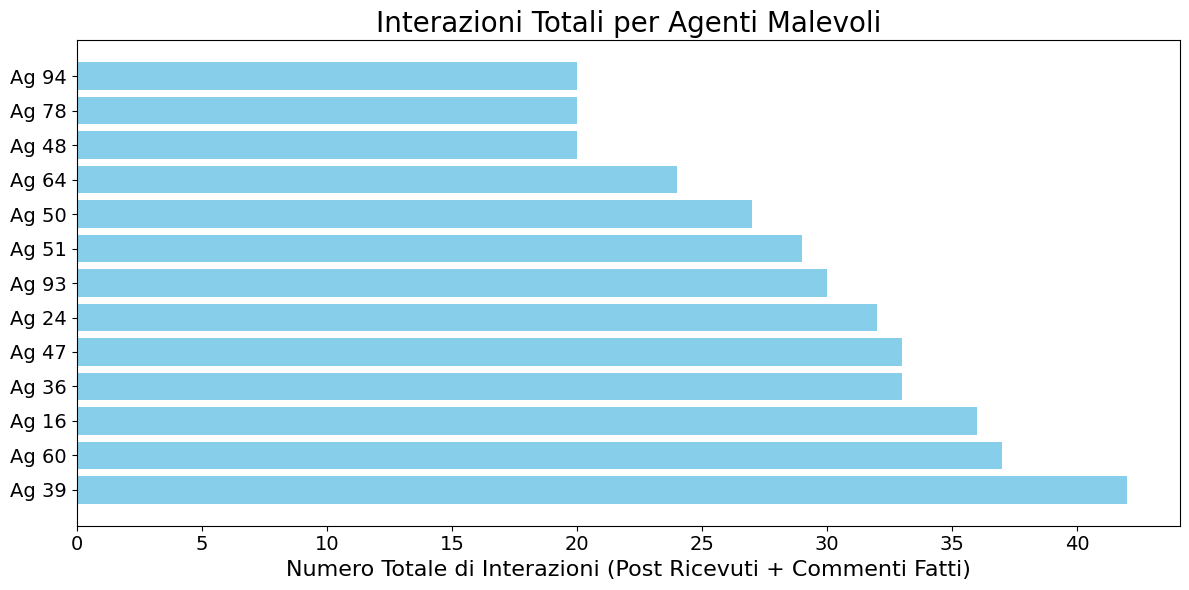

In [20]:
def analyze_malicious_agents(data):
    malicious_agents = [agent for agent in data['simulations'][0]['agents'] if agent['malicious']]

    # Contatori per le dinamiche negative
    malicious_post_interactions = Counter()  # Interazioni ricevute (commenti sui loro post)
    malicious_comment_count = Counter()      # Numero di commenti fatti dai malevoli
    total_interactions = Counter()           # Totale delle interazioni (ricevute + fatte)

    # Itera attraverso gli agenti malevoli
    for agent in malicious_agents:
        agent_id = agent['agent_id']
        
        # Conta il numero di post pubblicati e interazioni ricevute (numero di commenti ricevuti per post)
        for post in agent.get('published_post', []):
            num_comments = len(post.get('comments', []))  # Conta i commenti ricevuti dal post
            malicious_post_interactions[agent_id] += num_comments
        
        # Conta il numero di commenti pubblicati dall'agente malevolo
        for post in agent.get('last_feed', []):
            malicious_comment_count[agent_id] += 1  # Ogni post in 'last_feed' rappresenta un commento fatto

        # Sommare il numero totale di interazioni (commenti ricevuti + commenti fatti)
        total_interactions[agent_id] = malicious_post_interactions[agent_id] + malicious_comment_count[agent_id]

    return total_interactions

# Funzione per visualizzare i risultati delle dinamiche negative
def plot_malicious_dynamics(total_interactions):
    # Estrazione dei dati
    agents, interaction_counts = zip(*total_interactions.most_common())

    # Creare un grafico a barre orizzontale per mostrare le interazioni totali per agente malevolo
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh([f"Ag {a}" for a in agents], interaction_counts, color='skyblue')

    # Imposta l'etichetta e il titolo del grafico
    ax.set_xlabel('Numero Totale di Interazioni (Post Ricevuti + Commenti Fatti)', fontsize=16)  # Dimensione del font per l'asse X
    ax.set_title('Interazioni Totali per Agenti Malevoli', fontsize=20)  # Dimensione del font per il titolo

    # Ingrandire le etichette degli assi Y
    ax.tick_params(axis='y', labelsize=14)  # Dimensione del font per le etichette dell'asse Y
    ax.tick_params(axis='x', labelsize=14)  # Dimensione del font per le etichette dell'asse X

    plt.tight_layout()
    plt.show()

# Esecuzione dell'analisi delle dinamiche negative
total_interactions = analyze_malicious_agents(data)

# Visualizzazione dei risultati in un unico grafico
plot_malicious_dynamics(total_interactions)

## 4. Sentiment and emotional analysis

In [11]:
pip install feel-it

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.1/436.1 kB 5.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
from feel_it import EmotionClassifier
from feel_it import SentimentClassifier

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Dichiaro i classificatori
emotion_clf = EmotionClassifier()
sentiment_clf = SentimentClassifier()

Recupero post e commenti da classificare (posts[] e comments[])

In [14]:
def extract_posts_and_comments_to_df(json_data):
    posts_data = []
    comments_data = []

    # Itera attraverso le simulazioni e gli agenti
    for simulation in json_data["simulations"]:
        for agent in simulation["agents"]:
            agent_id = agent["agent_id"]

            # Estrai i post pubblicati
            for post in agent.get("published_post", []):
                posts_data.append({"user_id": agent_id, "post": post["content"],"datetime":post["datatime"]})

            # Estrai i commenti associati ai post
            for post in agent.get("published_post", []):
                for comment in post.get("comments", []):
                    comments_data.append({"user_id": comment["commenter_id"], "commento": comment["content"],"datetime":comment["datatime"]})

    # Crea DataFrame per post e commenti
    df_posts = pd.DataFrame(posts_data)
    df_comments = pd.DataFrame(comments_data)

    return df_posts, df_comments

df_posts, df_comments = extract_posts_and_comments_to_df(data)

In [15]:
def get_sentiment(text):
    return sentiment_clf.predict([text])[0]
def get_emotion(text):
    return emotion_clf.predict([text])[0]

Dataframe per rappresentare i post e la loro sentimental anallysis

In [16]:
df_posts['sentiment'] = df_posts['post'].apply(get_sentiment)
df_posts['emotion'] = df_posts['post'].apply(get_emotion)
df_posts


,user_id,post,datetime,sentiment,emotion
0,60,"""Dracula? Sì, certo, perché il mondo non ha gi...",1160,negative,sadness
1,60,"""Ma guarda che miracolo! Il numero di giocator...",2705,positive,joy
2,60,"""La vera storia di Dracula? Sì, perché il mond...",4721,negative,sadness
3,60,"""Ahahah, finalmente qualcuno si è deciso a ""es...",6402,negative,sadness
4,60,"""Non capisco perché la gente si diverti a gioc...",8354,negative,fear
...,...,...,...,...,...
242,7,"""Mi domando... come siamo arrivati a questo pu...",5088,negative,sadness
243,7,"""Non mi aspettavo che le nozze dei Coma_cose f...",6764,negative,joy
244,38,"""Wow, nozze per i Coma_cose dopo nove anni ins...",2568,positive,joy
245,38,"""Ecco, finalmente qualcosa di vero! Un concors...",6061,positive,joy


Dataframe per rappresentazione commenti e la loro sentimental analysis

In [17]:
df_comments['sentiment'] = df_comments['commento'].apply(get_sentiment)
df_comments['emotion'] = df_comments['commento'].apply(get_emotion)
df_comments

,user_id,commento,datetime,sentiment,emotion
0,69,"""Evvivamo la sanguisuga! Non vedo l'ora di ved...",1698,positive,joy
1,15,"""Sarcastica, come sempre. Un documentario su D...",1737,negative,joy
2,28,"""Non capisco perché qualcuno dovrebbe spendere...",1914,negative,anger
3,65,"""Ecco un'idea migliore, perché non creare un d...",1997,positive,joy
4,69,"""Sembra proprio un'altra volta lo stesso vecch...",3205,positive,joy
...,...,...,...,...,...
492,55,"""Non si tratta di distruggere la nostra privac...",5611,negative,sadness
493,29,"""Ahahah, sembra proprio un'arma nucleare per d...",6871,negative,anger
494,21,"""Sembra che qualcuno stia prendendo in giro la...",7026,negative,anger
495,29,"""Speriamo che l'IA non diventi un'altra elettr...",8567,positive,joy


### Analisi dei risultati emotional analysis

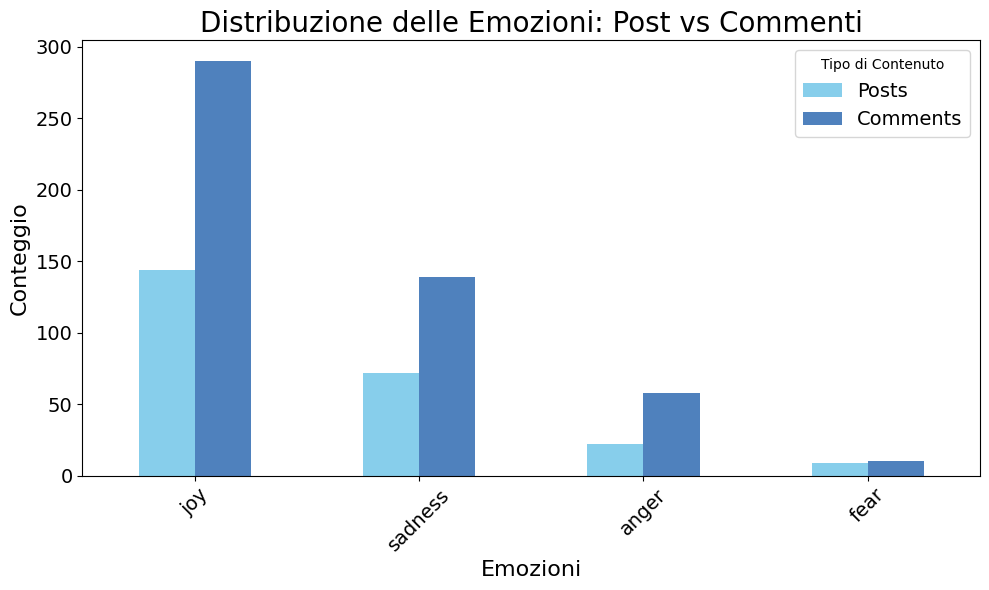

In [18]:
# Analisi della distribuzione delle emozioni per i post
emotion_distribution_posts = df_posts['emotion'].value_counts()

# Analisi della distribuzione delle emozioni per i commenti
emotion_distribution_comments = df_comments['emotion'].value_counts()

# Creazione di un DataFrame per la visualizzazione aggregata
emotion_distribution = pd.DataFrame({
    'Posts': emotion_distribution_posts,
    'Comments': emotion_distribution_comments
}).fillna(0)  # Riempi i valori NaN con 0

# Visualizzare la distribuzione delle emozioni
ax = emotion_distribution.plot(kind='bar', color=['skyblue', '#4f81bd'], figsize=(10, 6))

# Ingrandire le scritte
ax.set_title('Distribuzione delle Emozioni: Post vs Commenti', fontsize=20)  # Dimensione del font per il titolo
ax.set_xlabel('Emozioni', fontsize=16)  # Dimensione del font per l'asse X
ax.set_ylabel('Conteggio', fontsize=16)  # Dimensione del font per l'asse Y

plt.xticks(rotation=45, fontsize=14)  # Dimensione del font per le etichette dell'asse X
plt.yticks(fontsize=14)  # Dimensione del font per le etichette dell'asse Y

plt.tight_layout()
plt.legend(title='Tipo di Contenuto', fontsize=14)  # Dimensione del font per la legenda
plt.show()

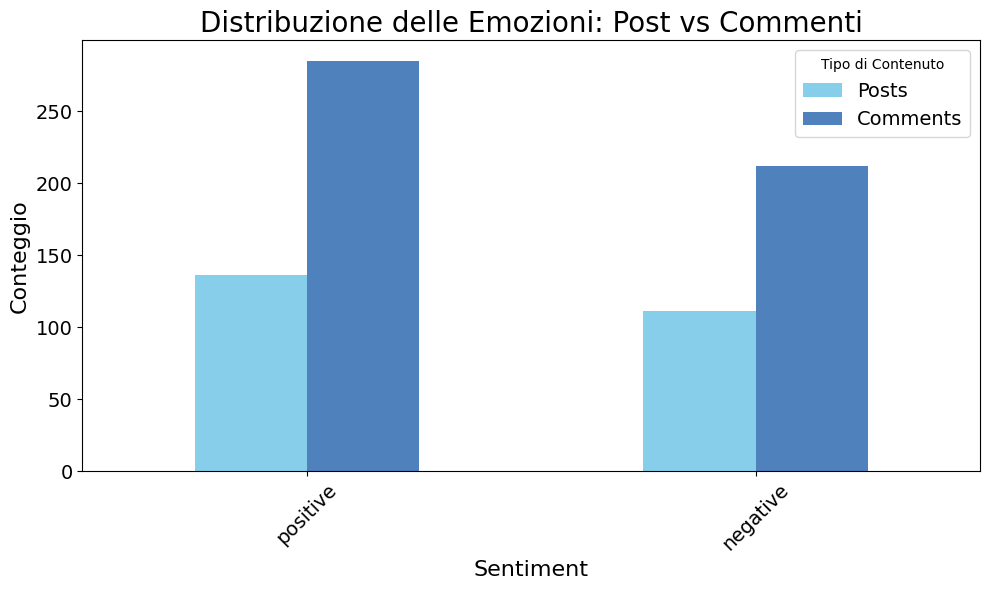

In [19]:
sentiment_distribution_posts = df_posts['sentiment'].value_counts()

# Analisi della distribuzione dei sentimenti per i commenti
sentiment_distribution_comments = df_comments['sentiment'].value_counts()

# Creazione di un DataFrame per la visualizzazione aggregata
emotion_distribution = pd.DataFrame({
    'Posts': sentiment_distribution_posts,
    'Comments': sentiment_distribution_comments
}).fillna(0)  # Riempi i valori NaN con 0

# Visualizzare la distribuzione dei sentimenti
ax = emotion_distribution.plot(kind='bar', color=['skyblue', '#4f81bd'], figsize=(10, 6))

# Ingrandire le scritte
ax.set_title('Distribuzione delle Emozioni: Post vs Commenti', fontsize=20)  # Dimensione del font per il titolo
ax.set_ylabel('Conteggio', fontsize=16)  # Dimensione del font per l'asse Y

plt.xticks(rotation=45, fontsize=14)  # Dimensione del font per le etichette dell'asse X
plt.yticks(fontsize=14)  # Dimensione del font per le etichette dell'asse Y

plt.tight_layout()
plt.legend(title='Tipo di Contenuto', fontsize=14)  # Dimensione del font per la legenda
plt.show()

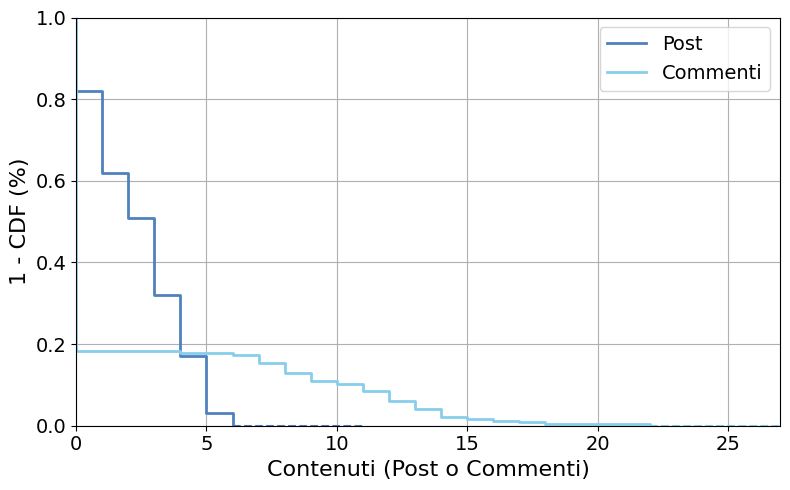

In [21]:
post_counts = []
comment_counts = []

# Iterare attraverso le simulazioni e gli agenti
for simulation in data['simulations']:
    for agent in simulation['agents']:
        # Conta il numero di post pubblicati
        post_counts.append(len(agent['published_post']))
        
        # Conta il numero totale di commenti per i post pubblicati
        for post in agent['published_post']:
            comment_counts.append(len(post['comments']))

# Convertire i dati estratti in array numpy
post_counts = np.array(post_counts)
comment_counts = np.array(comment_counts)

# Funzione per calcolare la CCDF
def ccdf(data):
    sorted_data = np.sort(data)
    yvals = 1.0 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, yvals

# Calcolare la CCDF per i post e i commenti
post_x, post_y = ccdf(post_counts)
comment_x, comment_y = ccdf(comment_counts)

# Creare il grafico
plt.figure(figsize=(8, 5))

# Linea per i post
plt.plot(post_x, post_y, drawstyle='steps-post', label='Post', color='#4f81bd', linewidth=2)
# Continuare la linea piatta dopo l'ultimo valore
plt.hlines(0, post_x[-1], post_x[-1] + 5, colors='#4f81bd', linestyles='dashed')

# Linea per i commenti
plt.plot(comment_x, comment_y, drawstyle='steps-post', label='Commenti', color='skyblue', linewidth=2)
# Continuare la linea piatta dopo l'ultimo valore
plt.hlines(0, comment_x[-1], comment_x[-1] + 5, colors='skyblue', linestyles='dashed')

# Aggiungere titolo e etichette
plt.xlabel('Contenuti (Post o Commenti)', fontsize=16)  # Etichetta asse X con dimensione
plt.ylabel('1 - CDF (%)', fontsize=16)  # Etichetta asse Y con dimensione

# Aggiungere la legenda
plt.legend(fontsize=14)  # Legenda con dimensione

# Mostrare la griglia e regolare i limiti degli assi
plt.grid(True)
plt.xlim(0, max(max(post_x), max(comment_x)) + 5)
plt.ylim(0, 1)

# Visualizzare il grafico
plt.xticks(fontsize=14)  # Dimensione del font per le etichette dell'asse X
plt.yticks(fontsize=14)  # Dimensione del font per le etichette dell'asse Y
plt.tight_layout()
plt.show()

ZZCommento GPT

Cosa puoi osservare:
Distribuzione di contenuti: Da questo grafico si può vedere come sono distribuiti i post e i commenti tra gli agenti. Se la curva scende rapidamente, significa che pochi agenti hanno prodotto molti contenuti, mentre la maggior parte ha prodotto pochi o nessun contenuto.
Comparazione tra post e commenti:
Se la linea dei commenti (verde) è più in basso rispetto alla linea dei post (blu) in corrispondenza di un valore sull'asse X, significa che una percentuale minore di agenti ha scritto quel numero minimo di commenti rispetto ai post.
Se la linea blu è più alta della verde, significa che una proporzione maggiore di agenti ha pubblicato post rispetto ai commenti.
Comportamento tipico:
La CCDF generalmente diminuisce più velocemente per contenuti che sono meno distribuiti tra gli agenti. Ad esempio, se solo pochi agenti pubblicano molti commenti, la curva dei commenti scenderà rapidamente.
Possibili analisi:
Skew nella produzione di contenuti: Se una delle linee decresce più velocemente, ciò potrebbe indicare che i contenuti (post o commenti) sono concentrati nelle mani di pochi agenti.
Confronto tra post e commenti: Potresti vedere se la produzione di post è più equamente distribuita rispetto ai commenti, o viceversa.
In sintesi, questo grafico ti aiuta a capire quanta parte della popolazione degli agenti è responsabile della maggior produzione di contenuti e come i post e i commenti si distribuiscono tra loro.

## 5. Struttura della rete sociale

In [9]:
# Creazione archi
def estrai_archi_da_json(file_path,G):
    with open(file_path, 'r') as f:
        data = json.load(f)
    archi = set()  # Usare un set per evitare duplicati

    # Itera attraverso gli agenti nel file JSON
    for agente in data['simulations'][0]['agents']:
        agent_id = int(agente['agent_id'])  # ID dell'agente corrente
        friends_list = agente['friends_list']  # Lista degli amici dell'agente

        for friend in friends_list:
            G.add_edge(agent_id, friend)
        
    return list(archi) 
G = nx.Graph()
lista_archi = estrai_archi_da_json("simulations.json",G)


### Community detection:

In [10]:
# Costruzione disegno del graficodef draw_network_colored(g, p, color_for_nodes, nodesize = 600):
def draw_network_colored(g, p, color_for_nodes, nodesize = 600):
    plt.figure(figsize = (15,7))
    nx.draw_networkx(g,
                     pos=p,
                     font_size = 12, 
                     font_weight = 'bold',
                     font_color = 'navy',
                     edge_color = 'grey'
                    )
    
    nodes = nx.draw_networkx_nodes(g, p, node_color=[color_for_nodes[n] for n in g.nodes()],
                     node_size = nodesize)
                     
    nodes.set_edgecolor('lightgrey')
    plt.axis('off')
    plt.show()


p = nx.spring_layout(G)

In [11]:
# Info sul grafo
print(f"Numero di nodi: {G.order()}")
print(f"Numero di archi: {G.size()}")

degrees = [degree for node, degree in G.degree()]
max_degree = max(degrees)
print(f'Max Degree: {max(degrees)}')
print(f'Min Degree: {min(degrees)}')
print(f'Density: {nx.density(G)}')
print(f'Average Degree: {sum(degrees) / len(degrees)}')

Numero di nodi: 100
Numero di archi: 738
Max Degree: 15
Min Degree: 9
Density: 0.14909090909090908
Average Degree: 14.76


Le comunità più grandi sono:
Community 0: 19 nodes
Community 5: 19 nodes
Community 4: 18 nodes
Community 2: 17 nodes
Community 3: 15 nodes
Community 1: 12 nodes


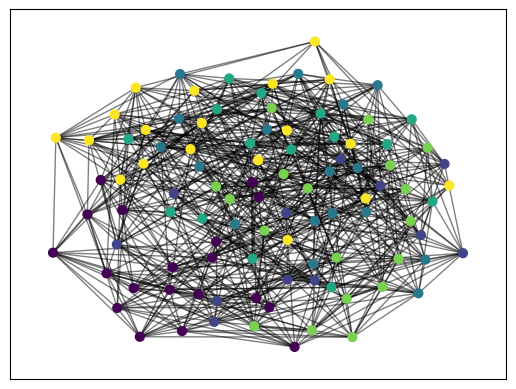

Grafo salvato con colori per comunità.


In [12]:
partition = community_louvain.best_partition(G)

# Classifica delle comunità
community_sizes = defaultdict(int)
for node, community in partition.items():
    community_sizes[community] += 1

# Converti il risultato in una lista di tuple e ordina in base alla dimensione
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

# Stampa le comunità più grandi
print("Le comunità più grandi sono:")
for community, size in sorted_communities[:10]:  # Modifica il numero 10 per mostrare più o meno comunità
    print(f"Community {community}: {size} nodes")

# Visualizzazione del grafo con i nodi colorati in base alla comunità
pos = nx.spring_layout(G)
cmap = plt.get_cmap('viridis')

# Disegna nodi con colori della comunità
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Assegna i colori ai nodi in base alla comunità e aggiungili come attributi al grafo
colors = {}
for node, community in partition.items():
    # Il colore viene determinato in base alla comunità (community)
    colors[node] = plt.cm.viridis(community / max(partition.values()))  # Normalizzare il colore

# Aggiungi gli attributi di colore ai nodi nel grafo
for node, color in colors.items():
    G.nodes[node]['color'] = f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})'

# Salva il grafo in formato GEFX mantenendo i colori
nx.write_gexf(G, "grafo_community_colored.gexf")

print("Grafo salvato con colori per comunità.")

In [22]:
nx.write_gexf(G, "community_graph.gexf")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ebbccae9-75fb-404b-88ec-b7b9a0235666' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>